Here we engineer several sets of features for prediction of Yelp rating from reviews.  The features here are derived from the results of LDA on the pooled reviews, which identified 5 topics.  First words in each review are tokenized and grouped by sentence. The 4 topic lda model is applied to each sentence. A sentence is assigned to a topic if that topic makes up more than 50% of that sentence. A sentiment analyzer is applied to the sentence.  The sentiment score of the topic for that review is the sum of the sentiment scores for the sentences assigned to that topic. The number of words assigned to the topic is also used.  Finally we measure the number of words used to describe each topic in the review.

In [40]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#import en_core_web_sm

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

from helper_functions import nlp_helpers

import pickle
from gensim.test.utils import datapath
from gensim.models import LdaModel
from gensim import corpora

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
sentdf = pd.read_csv('./ProcessedData/reviewsent_sentiment_thresh0.2soft.csv')

reviews.rename(columns = {'rating':'review_rating'},inplace=True)
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])


In [30]:
print(merged.columns)
merged.mreviewtxt[0]
print(merged.shape)
print(merged.alias.nunique())

merged = merged.dropna(axis=0)
print(merged.shape)
print(merged.alias.nunique())

Index(['id', 'name', 'alias', 'is_closed', 'review_count', 'price', 'rating',
       'transactions', 'latitude', 'longitude', 'geometry', 'index_right',
       'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'catlist', 'numcoffeemen', 'numreviews',
       'fraccof', 'name_top5count', 'reviewidx', 'shopidx', 'date',
       'revrating', 'reviewtxt', 'mreviewtxt', 'review_lem_noun',
       'review_lem_nounverb', 'review_lem_nounadj', 'reviewtxt_periodonly',
       'review_lem_withperiod'],
      dtype='object')
(46077, 35)
791
(44651, 35)
744


#For updating the lda model in the nlp_envp3 virtual envrionment

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.id2word thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.id2word

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.state thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.state

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.expElogbeta.npy thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.expElogbeta.npy

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim               

In [10]:
#Loading the previously trained LDA model

dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)


In [11]:
#extracting compound sentiment from reviews
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vs = [analyzer.polarity_scores(txt)['compound'] for txt in merged.reviewtxt.to_list()]

In [12]:
#extracting lda vectors
ldavecs = nlp_helpers.getldavec(merged.review_lem_noun.tolist(),dictionary,lda)

In [35]:
ldasentdf = sentdf.groupby(['reviewidx']).mean()
ldasentdf.rename(columns = {'vs':'vadersentiment_sentavg'},inplace=True)
ldasentdf.fillna(value=0,inplace=True)
ldasentdf.reset_index(inplace=True)

In [36]:
ldasentdf.head(10)

,reviewidx,vadersentiment_sentavg,t0s,t1s,t2s,t3s,t4s
0,6,0.222138,0.000000,0.281038,0.115341,-0.056099,0.127713
1,7,0.368300,0.187802,0.240309,0.105292,0.000000,0.168450
2,8,0.441480,0.092740,0.247843,0.101971,0.164570,0.185480
3,9,0.248273,0.086445,0.122320,0.053155,0.181225,0.000000
4,10,0.294225,0.000000,0.082292,-0.067013,0.140898,0.000000
5,11,0.949200,0.000000,0.719694,0.000000,0.000000,0.000000
6,12,0.294600,0.152358,0.062358,0.000000,0.000000,0.000000
7,13,-0.101150,-0.044056,0.000000,0.000000,0.000000,-0.089023
8,14,0.534567,0.266419,0.000000,0.391827,0.236768,0.191037
9,15,0.150100,0.287370,-0.035928,-0.090483,0.085458,0.138890


In [37]:
ldavecdf = pd.DataFrame(ldavecs)
ldavecdf.columns = ['t' + str(i) for i in range(5)]
ldavecdf.fillna(value=0,inplace=True)

merged.reset_index(inplace=True,drop=True)
print(merged.shape)

merged = merged.merge(ldasentdf,how = 'inner',on = 'reviewidx')
print(merged.shape)
print(merged.columns)

merged.reset_index(inplace=True,drop=True)
merged = pd.concat([merged,ldavecdf],axis=1)
merged['vadersentiment'] = pd.Series(vs)
print(merged.shape)

(44651, 35)
(44649, 41)
Index(['id', 'name', 'alias', 'is_closed', 'review_count', 'price', 'rating',
       'transactions', 'latitude', 'longitude', 'geometry', 'index_right',
       'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'catlist', 'numcoffeemen', 'numreviews',
       'fraccof', 'name_top5count', 'reviewidx', 'shopidx', 'date',
       'revrating', 'reviewtxt', 'mreviewtxt', 'review_lem_noun',
       'review_lem_nounverb', 'review_lem_nounadj', 'reviewtxt_periodonly',
       'review_lem_withperiod', 'vadersentiment_sentavg', 't0s', 't1s', 't2s',
       't3s', 't4s'],
      dtype='object')
(44651, 47)


In [38]:
merged = merged[~merged.isnull().any(axis=1)]

merged.columns

Index(['id', 'name', 'alias', 'is_closed', 'review_count', 'price', 'rating',
       'transactions', 'latitude', 'longitude', 'geometry', 'index_right',
       'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'catlist', 'numcoffeemen', 'numreviews',
       'fraccof', 'name_top5count', 'reviewidx', 'shopidx', 'date',
       'revrating', 'reviewtxt', 'mreviewtxt', 'review_lem_noun',
       'review_lem_nounverb', 'review_lem_nounadj', 'reviewtxt_periodonly',
       'review_lem_withperiod', 'vadersentiment_sentavg', 't0s', 't1s', 't2s',
       't3s', 't4s', 't0', 't1', 't2', 't3', 't4', 'vadersentiment'],
      dtype='object')

In [39]:
merged.to_csv('./ProcessedData/reviews_withlda5topicfeatures.csv',index=False)

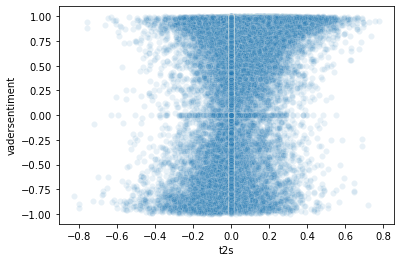

In [50]:
sns.scatterplot('t2s','vadersentiment',data=merged,alpha=0.1)
#sns.scatterplot('vadersentiment','vadersentiment_sentavg',data=merged,alpha=0.1)